# LDA model on oncology

provider_type: hematology, medical
- filter out least and most common hcpcs_codes (compared to model 1, which does no filtering)
- only consider in-facility claims
- number of topics == ?

In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import time

from gensim import matutils, models, corpora

%matplotlib inline
sns.set(style="white")

In [2]:
## connect to database
con = psycopg2.connect("dbname='doctordb' user='cathy'")

In [5]:
q = """SELECT npi, provider_type, hcpcs_code, hcpcs_description, bene_day_srvc_cnt
FROM payments 
WHERE (provider_type='Medical Oncology' OR provider_type='Hematology/Oncology')
AND place_of_service='O'
AND hcpcs_drug_indicator='Y'"""
payments = pd.read_sql_query(q, con=con)

In [6]:
payments.shape

(56147, 5)

In [7]:
payments['provider_type'].unique()

array(['Medical Oncology', 'Hematology/Oncology'], dtype=object)

In [8]:
## how many of each provider type?
payments.drop_duplicates('npi').groupby('provider_type')['npi'].count()

provider_type
Hematology/Oncology    3603
Medical Oncology       1056
Name: npi, dtype: int64

## construct raw data frame

In [9]:
by_npi = (payments[['npi','hcpcs_code','bene_day_srvc_cnt']].
                pivot(index='npi', values = 'bene_day_srvc_cnt', columns='hcpcs_code').
                fillna(value=0))
by_npi.shape

(4659, 175)

## preprocess data frame (drop top 3 codes, codes with only 1 claim, docs with < 1 claim)

### filter out extreme hcpcs_code columns (top 15 claimed codes, codes with fewer than 5 claims)

In [11]:
## What are the counts for the top claimed codes?
counts_per_code = (payments['hcpcs_code'].value_counts().
                   reset_index(name='count').
                   rename(columns={'index': 'hcpcs_code'}))

pd.set_option('max_colwidth', 80)
counts_per_code = (counts_per_code.merge(payments[['hcpcs_code', 'hcpcs_description']],
                                         on='hcpcs_code', sort=False)
                   .drop_duplicates())

top_codes_to_drop = list(counts_per_code['hcpcs_code'][:3])
counts_per_code.head(15)

,hcpcs_code,count,hcpcs_description
0,J1100,4044,"Injection, dexamethasone sodium phosphate, 1mg"
4044,J1200,3494,"Injection, diphenhydramine hcl, up to 50 mg"
7538,J2469,3056,"Injection, palonosetron hcl, 25 mcg"
10594,J2505,2325,"Injection, pegfilgrastim, 6 mg"
12919,J3489,2146,"Injection, zoledronic acid, 1 mg"
15065,J9045,2116,"Injection, carboplatin, 50 mg"
17181,J7030,2097,"Infusion, normal saline solution , 1000 cc"
19278,J3420,1994,"Injection, vitamin b-12 cyanocobalamin, up to 1000 mcg"
21272,J0897,1743,"Injection, denosumab, 1 mg"
23015,J2405,1656,"Injection, ondansetron hydrochloride, per 1 mg"


In [12]:
## How many codes have been claimed only once?
bottom_codes_to_drop = list(counts_per_code.query('count == 1')['hcpcs_code'])

In [13]:
len(bottom_codes_to_drop)

22

In [14]:
## so total columns dropped is:
print('number of cols to drop: {0}'.format(len(bottom_codes_to_drop) + len(top_codes_to_drop)))

number of cols to drop: 25


In [15]:
by_npi.drop(labels=(top_codes_to_drop + bottom_codes_to_drop), axis=1, inplace=True)
by_npi.shape

(4659, 150)

In [16]:
## write to file
by_npi.to_csv("11f_by_npi_reduced_medical_hematology_oncolgists.csv", index=True)

## LDA on filtered data frame using 5 topics

In [17]:
corpus = matutils.Dense2Corpus(by_npi.as_matrix(), documents_columns=False)

In [18]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [19]:
time0 = time.time()
ldamodel = models.ldamodel.LdaModel(corpus_tfidf, num_topics=5, passes=20)
print('calculated in {0}s'.format(time.time()-time0))

calculated in 73.04549360275269s


In [20]:
## Save model
ldamodel.save("11f_lda_5topics_colsDropped_docsDropped_hema_medi_oncology.model", pickle_protocol=3)

## Interpret the 5 topics in the model

In [21]:
## top 15 words in each topic
topics_matrix = ldamodel.show_topics(formatted=False, num_words=15)

In [22]:
## for each topic, store indices of top 20 hcpcs_codes in a list
topic_idx_dict = {}

for i in topics_matrix:
    topic_idx_dict[i[0]] = [int(word[0]) for word in i[1]]

In [23]:
## for each topic's list of indexes, get the list of hcpcs_codes
topic_dict = {}

for k, v in topic_idx_dict.items():
    topic_dict[k] = [by_npi.columns.values[i] for i in v]

In [24]:
## Topic 0
t = 0
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
2,J1626,"Injection, granisetron hydrochloride, 100 mcg"
4,J0885,"Injection, epoetin alfa, (for non-esrd use), 1000 units"
5,J0897,"Injection, denosumab, 1 mg"
8,J1442,"Injection, filgrastim (g-csf), 1 microgram"
14,J3420,"Injection, vitamin b-12 cyanocobalamin, up to 1000 mcg"
17,J3489,"Injection, zoledronic acid, 1 mg"
18,J7030,"Infusion, normal saline solution , 1000 cc"
31,J2780,"Injection, ranitidine hydrochloride, 25 mg"
33,J7040,"Infusion, normal saline solution, sterile (500 ml=1 unit)"
45,J7050,"Infusion, normal saline solution , 250 cc"


In [25]:
## Topic 1
t = 1
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
4,J0885,"Injection, epoetin alfa, (for non-esrd use), 1000 units"
5,J0897,"Injection, denosumab, 1 mg"
11,J1756,"Injection, iron sucrose, 1 mg"
14,J3420,"Injection, vitamin b-12 cyanocobalamin, up to 1000 mcg"
17,J3489,"Injection, zoledronic acid, 1 mg"
18,J7030,"Infusion, normal saline solution , 1000 cc"
55,J0881,"Injection, darbepoetin alfa, 1 microgram (non-esrd use)"
73,J1885,"Injection, ketorolac tromethamine, per 15 mg"
187,Q2036,"Influenza virus vaccine, split virus, when administered to individuals 3 yea..."
844,J2820,"Injection, sargramostim (gm-csf), 50 mcg"


In [26]:
## Topic 2
t = 2
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
4,J0885,"Injection, epoetin alfa, (for non-esrd use), 1000 units"
5,J0897,"Injection, denosumab, 1 mg"
8,J1442,"Injection, filgrastim (g-csf), 1 microgram"
10,J1750,"Injection, iron dextran, 50 mg"
13,J2505,"Injection, pegfilgrastim, 6 mg"
14,J3420,"Injection, vitamin b-12 cyanocobalamin, up to 1000 mcg"
17,J3489,"Injection, zoledronic acid, 1 mg"
18,J7030,"Infusion, normal saline solution , 1000 cc"
19,J9045,"Injection, carboplatin, 50 mg"
24,J9310,"Injection, rituximab, 100 mg"


In [27]:
## Topic 3
t = 3
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
2,J1626,"Injection, granisetron hydrochloride, 100 mcg"
5,J0897,"Injection, denosumab, 1 mg"
13,J2505,"Injection, pegfilgrastim, 6 mg"
17,J3489,"Injection, zoledronic acid, 1 mg"
18,J7030,"Infusion, normal saline solution , 1000 cc"
19,J9045,"Injection, carboplatin, 50 mg"
20,J9190,"Injection, fluorouracil, 500 mg"
21,J9201,"Injection, gemcitabine hydrochloride, 200 mg"
23,J9265,"Injection, paclitaxel, 30 mg"
31,J2780,"Injection, ranitidine hydrochloride, 25 mg"


In [28]:
## Topic 4
t = 4
(payments.loc[payments.hcpcs_code.isin(topic_dict[t]), ['hcpcs_code','hcpcs_description']].
 drop_duplicates('hcpcs_code'))

,hcpcs_code,hcpcs_description
5,J0897,"Injection, denosumab, 1 mg"
10,J1750,"Injection, iron dextran, 50 mg"
13,J2505,"Injection, pegfilgrastim, 6 mg"
14,J3420,"Injection, vitamin b-12 cyanocobalamin, up to 1000 mcg"
15,J3475,"Injection, magnesium sulfate, per 500 mg"
17,J3489,"Injection, zoledronic acid, 1 mg"
18,J7030,"Infusion, normal saline solution , 1000 cc"
19,J9045,"Injection, carboplatin, 50 mg"
23,J9265,"Injection, paclitaxel, 30 mg"
24,J9310,"Injection, rituximab, 100 mg"


## Plot distribution of providers per topic

In [29]:
## per document (provider), assign topic based on highest-probability topic out of the 10
topic_per_doc = []
for i in corpus_tfidf:
    topic_per_doc.append(np.argmax(np.array(ldamodel.get_document_topics(i))[:,1]))

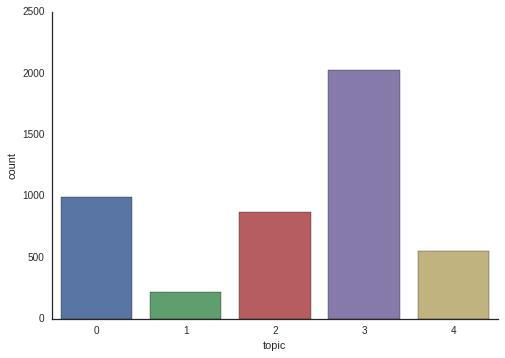

In [30]:
## distribution of providers among topics
ax = sns.countplot(x='topic',data=pd.DataFrame(topic_per_doc).rename(columns={0:'topic'}))
sns.despine()

## Color code distribution over topics by provider_type

In [31]:
by_npi.index = by_npi.index.astype(str)

In [32]:
color_codes = (pd.DataFrame({'npi':by_npi.index}).
               merge(payments.drop_duplicates('npi')[['npi', 'provider_type']]))

In [33]:
## color code for plotting
len(color_codes)

4659

In [34]:
color_codes.head()

,npi,provider_type
0,1003019571,Medical Oncology
1,1003031212,Hematology/Oncology
2,1003079997,Hematology/Oncology
3,1003099813,Hematology/Oncology
4,1003801689,Hematology/Oncology


In [35]:
topic_per_doc_df = (pd.concat([pd.DataFrame(topic_per_doc).rename(columns={0:'topic'}),
                              color_codes], axis=1, ignore_index=True).
                    rename(columns={0:'topic',1:'npi',2:'provider_type'}))

topic_per_doc_df.head()
#topic_per_doc_df = (pd.concat([pd.DataFrame(topic_per_doc), fraud_label], axis=1, ignore_index=True).
#                        rename(columns={0:'topic',1:'fraud'}))

,topic,npi,provider_type
0,3,1003019571,Medical Oncology
1,2,1003031212,Hematology/Oncology
2,3,1003079997,Hematology/Oncology
3,0,1003099813,Hematology/Oncology
4,3,1003801689,Hematology/Oncology


In [36]:
mydf = (topic_per_doc_df.
        groupby(['topic','provider_type']).
        count().
        rename(columns={'npi':'counts'}).
        reset_index())

In [37]:
mydf.head(10)

,topic,provider_type,counts
0,0,Hematology/Oncology,808
1,0,Medical Oncology,188
2,1,Hematology/Oncology,178
3,1,Medical Oncology,39
4,2,Hematology/Oncology,690
5,2,Medical Oncology,176
6,3,Hematology/Oncology,1467
7,3,Medical Oncology,557
8,4,Hematology/Oncology,460
9,4,Medical Oncology,96


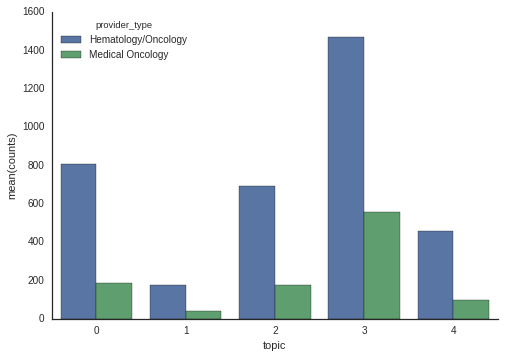

In [38]:
ax = sns.barplot(x='topic', y='counts', hue='provider_type', data=mydf)
sns.despine()

In [39]:
## plot fractions per provider_type rather than absolute counts across topics

## rescale each of the counts by overall total per fraud group
#mydf.groupby(['provider_type']).transform(lambda x: x.sum()['counts'])
types = list(payments['provider_type'].unique())

for t in types:
    mydf.loc[mydf.provider_type == t, 'counts']  = (mydf.loc[mydf.provider_type == t, 'counts'] / 
                                          float(sum(mydf.loc[mydf.provider_type == t, 'counts'])))

mydf.head()

,topic,provider_type,counts
0,0,Hematology/Oncology,0.224258
1,0,Medical Oncology,0.178030
2,1,Hematology/Oncology,0.049403
3,1,Medical Oncology,0.036932
4,2,Hematology/Oncology,0.191507


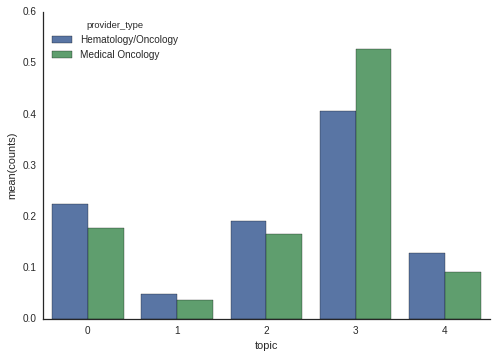

In [40]:
ax = sns.barplot(x='topic', y='counts', hue='provider_type', data=mydf)
sns.despine()

## Plot doctors in topic space

In [41]:
from sklearn.manifold import TSNE
#from sklearn import preprocessing

In [42]:
topics_per_doc = []

## Get features per doc (probability scores over topics)
for doc in corpus_tfidf:
    topics_per_doc.append(np.array(ldamodel.get_document_topics(doc))[:,1])

by_npi_topics = pd.DataFrame(topics_per_doc)
by_npi_topics.shape

(4659, 5)

In [43]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(by_npi_topics.as_matrix())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4659
[t-SNE] Computed conditional probabilities for sample 2000 / 4659
[t-SNE] Computed conditional probabilities for sample 3000 / 4659
[t-SNE] Computed conditional probabilities for sample 4000 / 4659
[t-SNE] Computed conditional probabilities for sample 4659 / 4659
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 1.7265815, gradient norm = 0.0100696
[t-SNE] Iteration 50: error = 1.6283587, gradient norm = 0.0065855
[t-SNE] Iteration 75: error = 1.2217159, gradient norm = 0.0027479
[t-SNE] Iteration 100: error = 1.1329919, gradient norm = 0.0022627
[t-SNE] Error after 100 iterations with early exaggeration: 1.132992
[t-SNE] Iteration 125: error = 0.9929127, gradient norm = 0.0016254
[t-SNE] Iteration 150: error = 0.9526306, gradient norm = 0.0014844
[t-SNE] Iteration 175: error = 0.9424084, gradient norm = 0.0014529
[t-SNE] Iteratio

In [44]:
X_embedded_df = pd.DataFrame(X_embedded)
X_embedded_df = (pd.concat([X_embedded_df, topic_per_doc_df['provider_type']], axis=1, ignore_index=True)).rename(columns={0:'x', 1:'y', 2:'provider_type'})

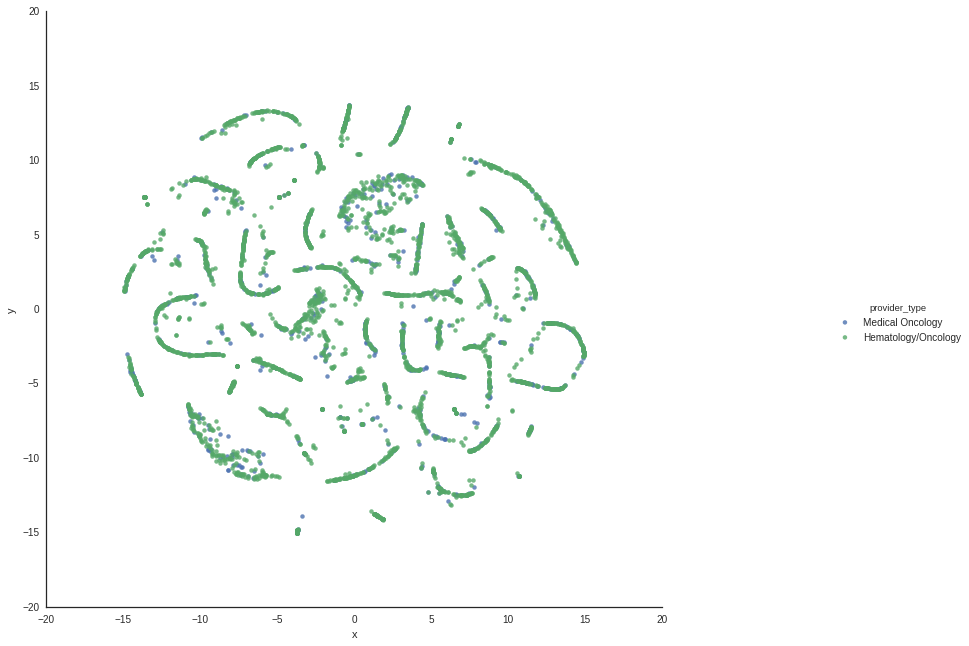

In [45]:
#plt.rcParams['figure.figsize'] = (20.0, 20.0)
#plt.figure(figsize=(8, 6))
plt.rcParams['figure.figsize']=(10,20)
fig = plt.figure(figsize=(10,10))
sns.lmplot(x='x', y='y', data=X_embedded_df, hue='provider_type', fit_reg=False)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(15)
#plt.rcParams['figure.figsize'] = (20.0, 20.0)

## tsne on original space

In [46]:
X_embedded0 = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(by_npi.as_matrix())

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 4659
[t-SNE] Computed conditional probabilities for sample 2000 / 4659
[t-SNE] Computed conditional probabilities for sample 3000 / 4659
[t-SNE] Computed conditional probabilities for sample 4000 / 4659
[t-SNE] Computed conditional probabilities for sample 4659 / 4659
[t-SNE] Mean sigma: 0.000000
[t-SNE] Iteration 25: error = 1.4693062, gradient norm = 0.0097312
[t-SNE] Iteration 50: error = 1.4129063, gradient norm = 0.0065684
[t-SNE] Iteration 75: error = 1.1812106, gradient norm = 0.0030059
[t-SNE] Iteration 100: error = 1.1294881, gradient norm = 0.0029412
[t-SNE] Error after 100 iterations with early exaggeration: 1.129488
[t-SNE] Iteration 125: error = 1.0359526, gradient norm = 0.0024978
[t-SNE] Iteration 150: error = 1.0046009, gradient norm = 0.0023488
[t-SNE] Iteration 175: error = 0.9972574, gradient norm = 0.0023210
[t-SNE] Iteratio

In [47]:
X_embedded_df0 = pd.DataFrame(X_embedded0)
X_embedded_df0 = (pd.concat([X_embedded_df0, topic_per_doc_df['provider_type']], axis=1, ignore_index=True)).rename(columns={0:'x', 1:'y', 2:'provider_type'})

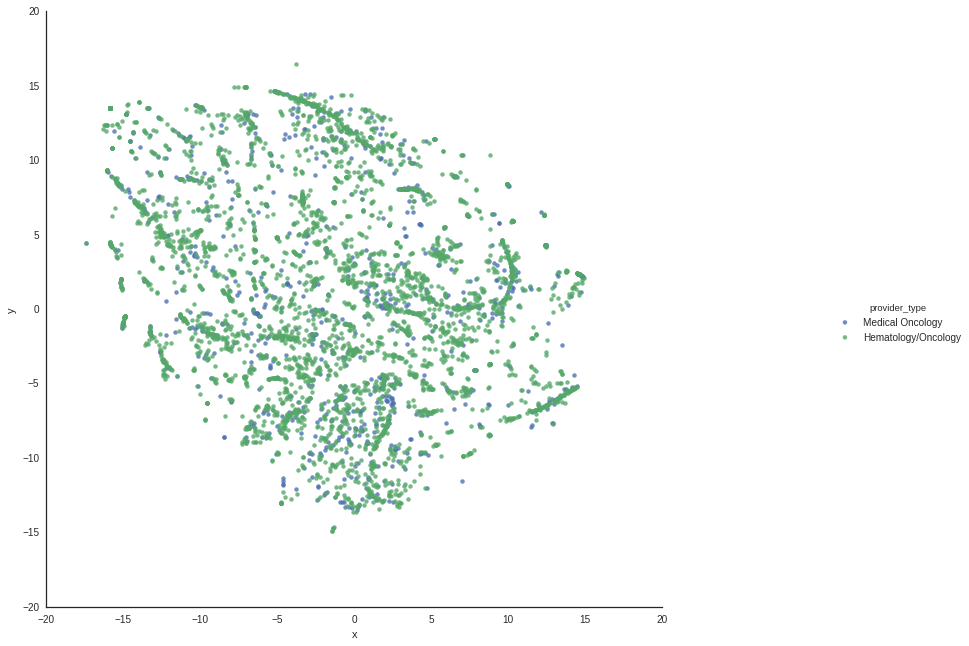

In [48]:
#plt.rcParams['figure.figsize'] = (20.0, 20.0)
#plt.figure(figsize=(8, 6))
plt.rcParams['figure.figsize']=(10,20)
fig = plt.figure(figsize=(10,10))
sns.lmplot(x='x', y='y', data=X_embedded_df0, hue='provider_type', fit_reg=False)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(15)
#plt.rcParams['figure.figsize'] = (20.0, 20.0)

## quantify sharpness of probability distribution over topics per doctor

In [49]:
by_npi_topics.head()

,0,1,2,3,4
0,0.101397,0.100000,0.100000,0.598537,0.100066
1,0.041867,0.066635,0.801631,0.047498,0.042369
2,0.059775,0.058598,0.361965,0.459955,0.059707
3,0.728185,0.065120,0.069953,0.068638,0.068104
4,0.072550,0.352790,0.068747,0.435718,0.070196


In [62]:
entropy_per_npi = by_npi_topics.apply(np.log, axis=1).mul(by_npi_topics).sum(axis=1)

In [63]:
len(entropy_per_npi)

4659

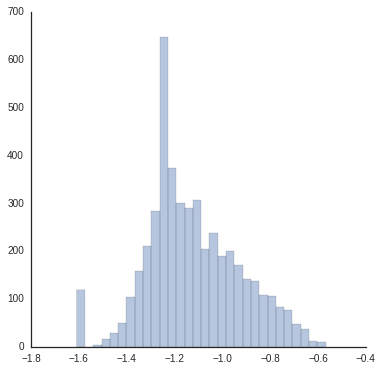

In [70]:
plt.rcParams['figure.figsize']=(6,6)
g = sns.distplot(entropy_per_npi, kde=False, bins=30)
#g.set(xlim=(0,500), ylim=(0, 60), xlabel='claims per drug B code', ylabel='counts')
sns.despine()   

In [67]:
##  maximum entropy over 5 topics = 5 * (1/5)log(1/5)
np.log(1/5)

-1.6094379124341003

There appear to be about 120 providers who have completely uniform probability distributions over the 5 topics.  Why is there a spike at about -1.25?

How is entropy distributed between provider_types?

In [75]:
entropy_df = pd.concat([color_codes, pd.DataFrame(entropy_per_npi)], axis=1).rename(columns={0:'entropy'})

In [85]:
entropy_df.head()

,npi,provider_type,entropy
0,1003019571,Medical Oncology,-1.230139
1,1003031212,Hematology/Oncology,-0.769256
2,1003079997,Hematology/Oncology,-1.227960
3,1003099813,Hematology/Oncology,-0.961779
4,1003801689,Hematology/Oncology,-1.290406


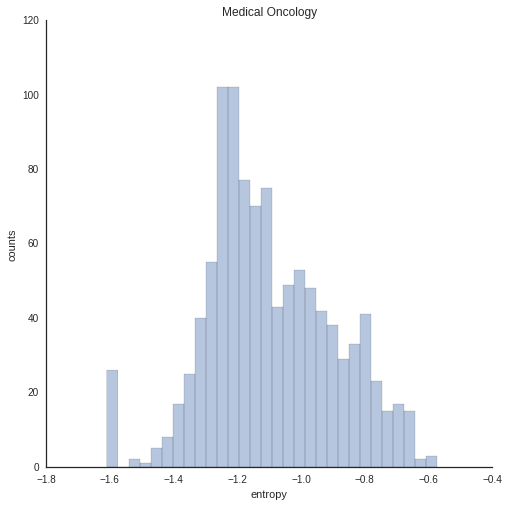

In [88]:
plt.rcParams['figure.figsize']=(8,8)
g = sns.distplot(entropy_df.query("provider_type=='Medical Oncology'")['entropy'], kde=False, bins=30)
g.set(xlabel='entropy', ylabel='counts', title='Medical Oncology')
sns.despine()

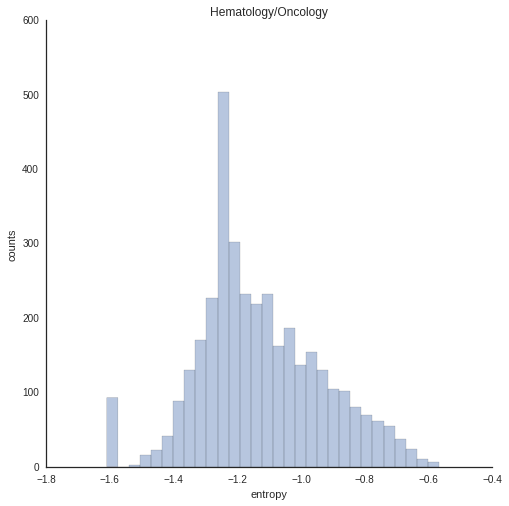

In [89]:
plt.rcParams['figure.figsize']=(8,8)
g = sns.distplot(entropy_df.query("provider_type=='Hematology/Oncology'")['entropy'], kde=False, bins=30)
g.set(xlabel='entropy', ylabel='counts', title='Hematology/Oncology')
sns.despine()